In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


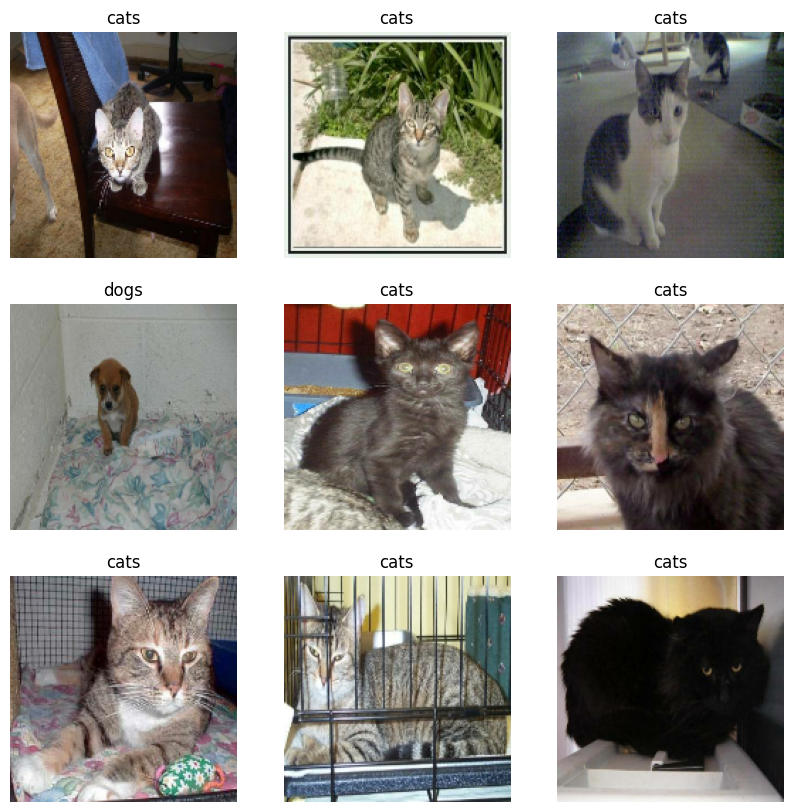

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

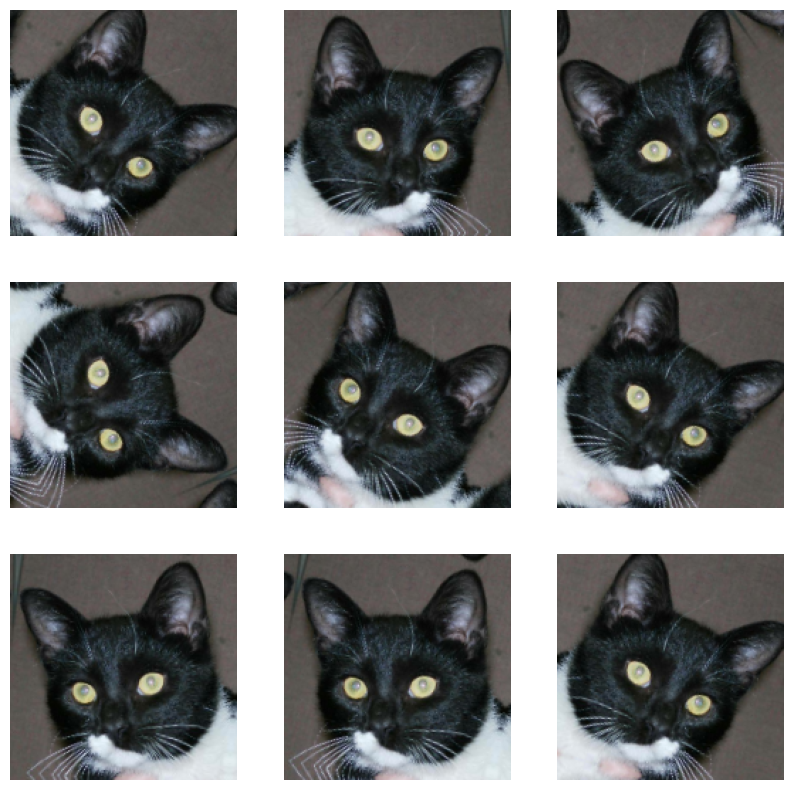

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 9s 100ms/step - loss: 0.8434 - accuracy: 0.4542


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.45


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 11s 88ms/step - loss: 0.7296 - accuracy: 0.5480 - val_loss: 0.5858 - val_accuracy: 0.6411
Epoch 2/10
63/63 [==============================] - 4s 61ms/step - loss: 0.5338 - accuracy: 0.6915 - val_loss: 0.4221 - val_accuracy: 0.7760
Epoch 3/10
63/63 [==============================] - 5s 79ms/step - loss: 0.4329 - accuracy: 0.7780 - val_loss: 0.3302 - val_accuracy: 0.8428
Epoch 4/10
63/63 [==============================] - 4s 62ms/step - loss: 0.3737 - accuracy: 0.8285 - val_loss: 0.2624 - val_accuracy: 0.8861
Epoch 5/10
63/63 [==============================] - 6s 92ms/step - loss: 0.3124 - accuracy: 0.8590 - val_loss: 0.2320 - val_accuracy: 0.8973
Epoch 6/10
63/63 [==============================] - 4s 61ms/step - loss: 0.2872 - accuracy: 0.8770 - val_loss: 0.2026 - val_accuracy: 0.9208
Epoch 7/10
63/63 [==============================] - 5s 78ms/step - loss: 0.2628 - accuracy: 0.8875 - val_loss: 0.1787 - val_accuracy: 0.9307
Epoch 8/10
6

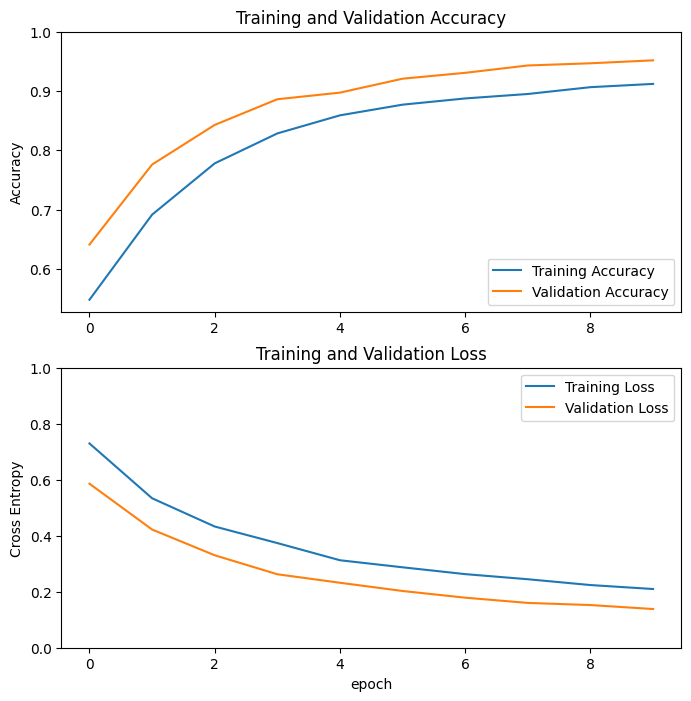

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,epochs=total_epochs,initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 19s 102ms/step - loss: 0.1537 - accuracy: 0.9320 - val_loss: 0.0602 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 6s 85ms/step - loss: 0.1012 - accuracy: 0.9615 - val_loss: 0.0447 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 4s 66ms/step - loss: 0.1086 - accuracy: 0.9585 - val_loss: 0.0453 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 6s 85ms/step - loss: 0.1149 - accuracy: 0.9495 - val_loss: 0.0497 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 4s 67ms/step - loss: 0.0905 - accuracy: 0.9590 - val_loss: 0.0423 - val_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 6s 88ms/step - loss: 0.0857 - accuracy: 0.9660 - val_loss: 0.0393 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 4s 66ms/step - loss: 0.0761 - accuracy: 0.9700 - val_loss: 0.0367 - val_accuracy: 0.9814
Epoc

In [ ]:
len(model.trainable_variables)


56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,epochs=total_epochs,initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 5s 78ms/step - loss: 0.0469 - accuracy: 0.9810 - val_loss: 0.0377 - val_accuracy: 0.9864
Epoch 11/20
63/63 [==============================] - 4s 67ms/step - loss: 0.0611 - accuracy: 0.9755 - val_loss: 0.0394 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 5s 82ms/step - loss: 0.0523 - accuracy: 0.9775 - val_loss: 0.0467 - val_accuracy: 0.9777
Epoch 13/20
63/63 [==============================] - 4s 66ms/step - loss: 0.0545 - accuracy: 0.9800 - val_loss: 0.0473 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 4s 67ms/step - loss: 0.0384 - accuracy: 0.9865 - val_loss: 0.0713 - val_accuracy: 0.9777
Epoch 15/20
63/63 [==============================] - 7s 96ms/step - loss: 0.0418 - accuracy: 0.9840 - val_loss: 0.0381 - val_accuracy: 0.9889
Epoch 16/20
63/63 [==============================] - 4s 67ms/step - loss: 0.0473 - accuracy: 0.9840 - val_loss: 0.0429 - val_accuracy: 0.9827
Epoch 

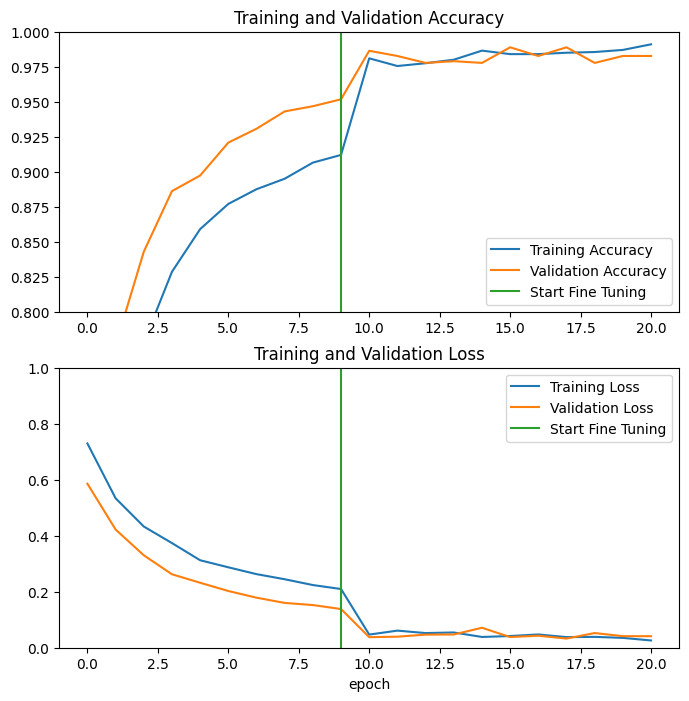

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 43ms/step - loss: 0.0099 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


Predictions:
 [0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0]
Labels:
 [0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0]


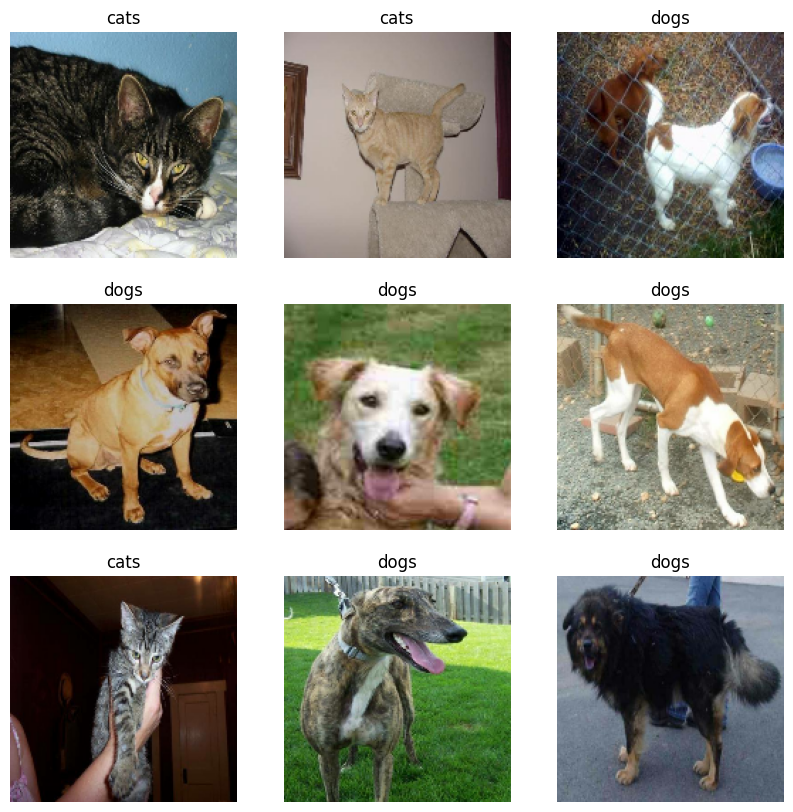

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")